# Initial experiment with GAN-based composition refinement 


In [1]:
import os
COCO_API_DIR = 'D:/Datasets/COCO/cocoapi-master/PythonAPI'
COCO_ROOT = 'D:/Datasets/COCO/'
COCO_SET = 'train2017'
import sys
import threading
from threading import Thread
import time
sys.path.append('../frontend')
sys.path.append('../backend')
sys.path.append(COCO_API_DIR)

import cv2
import datetime
import pickle
import json
import time
import glob
import timeit
import skimage.io as io
from scipy.ndimage.filters import gaussian_filter
from keras.layers import *
from keras.models import *
from keras import losses
from keras.callbacks import TensorBoard
from keras.optimizers import *
from IPython.display import clear_output
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import random
import datasets

c:\anaconda\envs\ml\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


LEye is not present
REye is not present
LEar is not present
REar is not present
Nose is not present
Background is not present
HeadTop is not present
Neck is not present
Chest is not present
Pelvis is not present
Background is not present


In [2]:
# Pickle stuff
def save_training_example(data_train):
    fname = 'ex_{}.pickle'.format(datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d%H%M%S'))
    fpath = os.path.join(GENERATED_TRAINING_EXAMPLES_OUTPUT_DIR, fname)
    with open(fpath, 'wb') as file:
        pickle.dump(data_train, file)
    return fpath
        
def load_training_example(fpath):
    with open(fpath, 'rb') as file:
        data_train = pickle.load(file)
        return data_train
    return None

def get_composite_mask(masks, dilation_size=0):
    out = masks[0]*0
    for mask in masks:
        if dilation_size > 0:
            kernel = np.ones((dilation_size,dilation_size), np.uint8)
            mask = cv2.dilate(mask, kernel)
        out = out + np.round(mask)
    return out


def scale_and_pad(image, longer_edge_out=255, pad_value=0, pad_mode='CENTER', scale_mode='max'):
    """Takes an image and rescales it with padding while keeping the ratio intact and putting image in the center or in the top-left corner """
    
    # Checking if the image is 2D or 3D (with channels)
    if(len(image.shape)>2):
        num_channels = image.shape[-1]
        image_scaled_and_padded = np.zeros((longer_edge_out,longer_edge_out,num_channels)) + pad_value
    else:
        num_channels = 1
        image_scaled_and_padded = np.zeros((longer_edge_out,longer_edge_out)) + pad_value

    # Calculate the scale according to the longer edge of image
#    if scale_mode=='min':
#        scale = float(longer_edge_out/ np.min([ image.shape[1], image.shape[0] ]))
#    else:
    scale = float(longer_edge_out/ np.max([ image.shape[1], image.shape[0] ]))        
    image = cv2.resize(image,None, fx=scale, fy=scale)
    if(pad_mode is 'CENTER'):
        shiftyx = (longer_edge_out-np.array(image.shape[0:2]))//2
    else:
        shiftyx = [0,0]
        
    # Put the image in place
    image_scaled_and_padded[shiftyx[0]:shiftyx[0]+image.shape[0], shiftyx[1]:shiftyx[1]+image.shape[1],] = image
    return image_scaled_and_padded, scale, shiftyx


# FIXME: Needs to be moved to untils.py when ready!
def get_augmentation_params(w,h, aug_shift_range=0, aug_rot_range=0, aug_scale_range=None, aug_shear_range=0):
    T = np.zeros((2,3))
    T[0,0] = 1
    T[1,1] = 1
    if aug_scale_range is not None:
        if type(aug_scale_range) is int or type(aug_scale_range) is float:
            s = np.random.uniform(1-aug_scale_range, 1+aug_scale_range, (1,))
        elif type(aug_scale_range) is tuple and len(aug_scale_range) == 2:
            s = np.random.uniform(aug_scale_range[0], aug_scale_range[1], (1,))
        T[0,0] = s
        T[1,1] = s
    
    # FIXME: Add shearing
    R = None
    if aug_shift_range > 0:
        shiftxy = np.random.uniform(-aug_shift_range,aug_shift_range,(2,))
        T += np.float32([[0,0,shiftxy[0]],[0,0,shiftxy[1]]]) # get the translation matrix
    if aug_rot_range != 0:                
        angle_deg = np.random.uniform(-aug_rot_range,aug_rot_range,(1,))[0]
        R = cv2.getRotationMatrix2D((w/2,h/2), angle_deg,1)
    return R, T

def coco_load_image(coco, coco_kps, imgId, catIds, coco_root, longer_edge_resize):
    # LOADING IMAGE INFO AND ANNOTATIONS
    img_info = coco.loadImgs(imgId)[0]
    annIds = coco_kps.getAnnIds(imgIds=img_info['id'], catIds=catIds)
    anns = coco_kps.loadAnns(annIds)    
    masks = [ coco.annToMask(mask_ann) for mask_ann in anns]
    
    # GETTING THE MASKS AND KEYPOINTS
    anns_out = []
    masks_out = []
    for i,ann in enumerate(anns):
        if ann['iscrowd'] is 0 and ann['num_keypoints'] > 0:
            anns_out.append(ann)
            masks_out.append(masks[i])
            
            
    masks_out = [scale_and_pad(masks_out[i], longer_edge_out=longer_edge_resize)[0] for i in range(0,len(masks_out))]
        
    # LOADING AND PRE-PROCESSING
    folder_name = img_info['coco_url'].split('/')[-2]
    fpath = os.path.join(coco_root,folder_name, img_info['file_name'])
    
    image = cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB)
    image_scaled_and_padded, scale, shiftyx = scale_and_pad(image, longer_edge_out=longer_edge_resize)
    
    ret = dict()
    ret['image'] = image
    ret['image_scaled_and_padded'] = image_scaled_and_padded
    ret['shiftyx'] = shiftyx
    ret['scale'] = scale
    ret['img_info'] = img_info
    ret['anns'] = anns_out
    ret['masks'] = masks_out
    return ret




def extract_dominant_person(I, longer_edge_size):
    biggest_mask_idx = np.argmax([ np.sum(mask) for mask in I['masks'] ])
    biggest_obj_mask = scale_and_pad(I['masks'][biggest_mask_idx], longer_edge_out=longer_edge_size, scale_mode='min')[0]
    biggest_obj_mask = (biggest_obj_mask> 0)
    biggest_obj_mask_3chn = np.stack([ biggest_obj_mask,biggest_obj_mask,biggest_obj_mask ], axis=2)
    biggest_obj = np.multiply(I['image_scaled_and_padded'], biggest_obj_mask_3chn)
    return biggest_obj, biggest_obj_mask
    
def generate_integer_mask(masks):
    """ Takes the masks as an output """
    image_edge = masks[0].shape[1]
    mask_out = np.zeros((image_edge, image_edge))
    
    j=1
    for mask in masks:
        mask = np.array(mask>0).astype(np.int32)
        mask_pixels = np.sum( mask )
        if mask_pixels > 30:
            mask = mask*(j)
            mask_out = mask_out*(mask==0) + mask
            j += 1
    
    # mask cleanup
    j=0
    for value in np.unique(mask_out):
        mask_out[ mask_out==value] = j
        j += 1

    return mask_out    

def filter_masks(masks):
    """ Takes the masks as an output """
    image_edge = masks[0].shape[1]
    masks_out = []
    
    for mask in masks:
        mask = np.array(mask>0).astype(np.uint8)
        mask_pixels = np.sum( mask )
        if mask_pixels > 30:
            masks_out.append(mask)
    

    return masks_out   

def get_image_suitable_for_blending_with_meta(coco, coco_kps, coco_root, imgIds , longer_edge_size, scale_range=(0.5,1.5), shift_range=0, rot_range=0, allow_overlaps=True, debug=False):
    mask_area_th = 0.10 # Percentage
    min_visible_kps = 6
    overlap_check_dilation_size = 15
    enforce_kps_vis = ['LShoulder', 'RShoulder', 'LHip', 'RHip']
    
    while 1:
        time_before = time.time()
        imgId = imgIds[np.random.uniform(0, len(imgIds), (1,)).astype(np.int32)[0]]
        IM = coco_load_image(coco, coco_kps, imgId, catIds, coco_root, longer_edge_size)
        time_after = time.time()
        timing_sampling = time_after-time_before
        
        
        time_before = time.time()
        # 0. At least one object in the image
        if(len(IM['masks']) == 0):
            if debug:
                print('Image needs to have at least 1 non-empty mask')
            continue
        
        # Filter the masks
        IM['masks'] = filter_masks(IM['masks'])
        if len(IM['masks']) == 0:
            if debug:
                print('Empty masks after filtering')
            continue

        
        # 1. Dominant object needs to be bigger than X% of the image
        biggest_mask_idx = np.argmax([ np.sum(mask) for mask in IM['masks'] ])
        biggest_mask_area_perc = np.sum(IM['masks'][biggest_mask_idx])/np.prod(IM['masks'][biggest_mask_idx].shape[0:2])
        if biggest_mask_area_perc < mask_area_th:
            if debug:
                print('Object not big enough! {} < {}'.format(biggest_mask_area_perc, mask_area_th))
            continue
    
    
        # 2. Minimum N keypoints visible
        dom_obj_kps = IM['anns'][biggest_mask_idx]['keypoints']
        num_visible_kps = np.sum([ dom_obj_kps[i+2]==2 for i in range(0,len(dom_obj_kps),3) ])
        if(num_visible_kps <min_visible_kps ):
            if debug:
                print('Not enough keypoints are visible!')
            continue
        if 0:
            if debug:
                print('Visible kps: {}'.format(num_visible_kps))
            plt.imshow( IM['masks'][biggest_mask_idx] )
            for i in range(0, len(dom_obj_kps),3):
                plt.plot( dom_obj_kps[i], dom_obj_kps[i+1], 'rx' )
            plt.show()
        
        # 3. Types of keypoints
        # We need to see the following keypoints
        #print(dom_obj_kps)
        kps_vis_pass = True
        for kp_name in enforce_kps_vis:
            i = datasets.KEYPOINT_LABELS_COCO.index(kp_name)
            #print( '{}: {}'.format( kp_name, dom_obj_kps[3*i :3*i+3] ))
            if( dom_obj_kps[3*i + 2] != 2 ):
                if debug:
                    print('{} is not visible!'.format(kp_name))
                kps_vis_pass = False
                break
        if kps_vis_pass is False:
            continue
                
        # 4. No "overlapping" regions
        if allow_overlaps is False:
            comp_mask = get_composite_mask(IM['masks'], dilation_size=overlap_check_dilation_size)
            if np.sum(comp_mask>1) > 0:
                if debug:
                    print('Overlaping object masks exist in the image, skipping')
                continue
        
        timing_per_image_checks = time.time()-time_before
        
        IM['timing_per_image_checks'] = timing_per_image_checks
        IM['timing_sampling'] = timing_sampling
        
        return IM
    
    
def scale_and_pad(image, longer_edge_out=255, pad_value=0, pad_mode='CENTER', scale_mode='max'):
    """Takes an image and rescales it with padding while keeping the ratio intact and putting image in the center or in the top-left corner """
    
    # Checking if the image is 2D or 3D (with channels)
    if(len(image.shape)>2):
        num_channels = image.shape[-1]
        image_scaled_and_padded = np.zeros((longer_edge_out,longer_edge_out,num_channels)) + pad_value
    else:
        num_channels = 1
        image_scaled_and_padded = np.zeros((longer_edge_out,longer_edge_out)) + pad_value

    # Calculate the scale according to the longer edge of image
#    if scale_mode=='min':
#        scale = float(longer_edge_out/ np.min([ image.shape[1], image.shape[0] ]))
#    else:
    scale = float(longer_edge_out/ np.max([ image.shape[1], image.shape[0] ]))     
        
    image = cv2.resize(image,None, fx=scale, fy=scale)
    if(pad_mode is 'CENTER'):
        shiftyx = (longer_edge_out-np.array(image.shape[0:2]))//2
    else:
        shiftyx = [0,0]
        
    # Put the image in place
    image_scaled_and_padded[shiftyx[0]:shiftyx[0]+image.shape[0], shiftyx[1]:shiftyx[1]+image.shape[1],] = image
    return image_scaled_and_padded, scale, shiftyx    
    
def load_and_preprocess_image(fpath, longer_edge_out=255, pad_value=0, scale_mode='max'):
    """ Loads file by path and performs scaling and padding using external routine """
    image = cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB)
    image_scaled_and_padded, scale, shiftyx = scale_and_pad(image, longer_edge_out=longer_edge_out, pad_value=pad_value, scale_mode=scale_mode)
    return image_scaled_and_padded, image, scale, shiftyx

    
    
def get_composition(coco, coco_kps, coco_root, imgIds, params, debug=False):
    # Get images A and B
    time_before = time.time()
    A = get_image_suitable_for_blending_with_meta(coco, coco_kps, coco_root, imgIds, longer_edge_size=params['longer_edge_size'], scale_range=params['scale_range_A'], shift_range=params['shift_range_A'], rot_range=params['rot_range_A'], allow_overlaps=params['allow_overlaps_in_A'])
    B = get_image_suitable_for_blending_with_meta(coco, coco_kps, coco_root, imgIds, longer_edge_size=params['longer_edge_size'], scale_range=params['scale_range_B'], shift_range=params['shift_range_B'], rot_range=params['rot_range_B'], allow_overlaps=params['allow_overlaps_in_B']) # we don't care about overlaps here
    
    B_person, B_person_mask = extract_dominant_person(B, longer_edge_size=params['longer_edge_size'])
    timing_images_sampling = time.time() - time_before
    
    # Composite images
    # Adding nincer blending Apr 6 2018
    
    # B-mask erosion
#    kernel = np.ones((erosion_ksize,erosion_ksize),np.uint8)
#    B_person_mask = cv2.erode(B_person_mask.astype(np.float32), kernel, iterations=erosion_iterations)
    
    # B-mask smoothing
#    kernel = np.ones((smooth_mask_ksize,smooth_mask_ksize),np.float32)/(smooth_mask_ksize*smooth_mask_ksize)
#    B_person_mask = cv2.filter2D(B_person_mask.astype(np.float32),-1,kernel).astype(np.float32)

    if 0:
        plt.imshow(A['image_scaled_and_padded'].astype(np.uint8))
        plt.show()

        plt.imshow(np.multiply(B['image_scaled_and_padded'], np.stack([ B_person_mask,B_person_mask,B_person_mask ], axis=2)).astype(np.uint8))
        plt.show()

    
    if 0:
        plt.imshow(B_person_mask)
        plt.show()
        plt.imshow(B_person_mask_smooth)
        plt.show()
        print('Smooth mask: {} to {}'.format( B_person_mask_smooth.min(), B_person_mask_smooth.max() ))
    
    
    img = np.multiply(A['image_scaled_and_padded'], np.stack([ 1-B_person_mask,1-B_person_mask,1-B_person_mask ], axis=2)) + \
            np.multiply(B['image_scaled_and_padded'], np.stack([ B_person_mask,B_person_mask,B_person_mask ], axis=2))

    if 0:
        plt.imshow(A['rect_scaled_and_padded'].astype(np.uint8))
        plt.show()
        
    masks = [ np.copy(mask) for mask in  A['masks'] ] 
    masks.append(  B_person_mask  )
    
    composite_mask = get_composite_mask(masks)

    # Heuristic: No mask can be occluded more than 100%
    for mask in A['masks']:
        mask_occ_perc = np.sum( mask*(composite_mask>1))/np.sum(mask>0)
        if mask_occ_perc > params['max_occ_perc_th']:
            if debug:
                print('One of the objects is {}% occluded!'.format(100*mask_occ_perc))
            return None
        if 0:
            plt.subplot(1,2,1)
            plt.imshow( mask )
            plt.subplot(1,2,2)
            plt.imshow(composite_mask)
            plt.title('Occlusion perc: {}'.format(mask_occ_perc))
            plt.show()
    
    if 0:
        # Heuristic: Finding the overlap
        overlap_perc = np.sum(composite_mask>1)/np.sum( composite_mask>0)
        if overlap_perc > params['overlap_perc_th']:
            if debug:
                print('Overlap per too high: {}'.format(overlap_perc))
            return None
    
    # 3 classes: 0-background, 1-single object, 2-more than 1 object occupying this pixel, start with all zeros
    gt = np.zeros((composite_mask.shape[0], composite_mask.shape[1], 3))
    gt[:,:,0] = composite_mask==0
    gt[:,:,1] = composite_mask==1
    gt[:,:,2] = composite_mask>1
    
    #print('Unique values in composite mask: {}'.format(np.unique(composite_mask)))

    occ_mask = (composite_mask>1)
    
    occ_mask_out = A['masks'][0]*0
    i=1
    for mask in A['masks']:
        # if not fully occluded:
        num_viz_pixels = np.sum(np.multiply(mask, 1-gt[:,:,2]))
        if 0:
            print('Object ID: {} number of visible pixels: {}'.format(i,num_viz_pixels ))
            plt.imshow(mask)
            plt.show()
            plt.imshow(1-gt[:,:,2])
            plt.show()
            
        if num_viz_pixels > 0:
            partial = (np.multiply( i*(mask>0) , occ_mask)).astype(np.uint8)
            if 0:
                plt.imshow(partial)
                plt.title('Partial occ mask {}\n values:{}'.format(i, np.unique(partial)))
                plt.show()
            occ_mask_out += partial
            
        i+=1

    # generate output
    out = dict()
    out['A'] = A
    out['B'] = B
    out['inserted'] = np.multiply(B['image_scaled_and_padded'], np.stack([ B_person_mask,B_person_mask,B_person_mask ], axis=2))
    out['y'] = np.expand_dims(gt[::8,::8,:], 0)
    out['occ_mask'] = occ_mask_out[::8,::8]
    out['masks'] = masks
    out['pixelid'] = generate_integer_mask(masks)[::8,::8]
    out['masks_small'] = [ mask[::8,::8] for mask in masks ]
    out['image_scaled_and_padded'] = img
    return out


composition_params = dict()
composition_params['longer_edge_size'] = 368
composition_params['erosion_ksize'] = 3
composition_params['erosion_iterations'] = 3
composition_params['smooth_mask_ksize'] = 3
composition_params['overlap_perc_th'] = 0.8
composition_params['max_occ_perc_th'] = 0.8
composition_params['allow_overlaps_in_A'] = True
composition_params['allow_overlaps_in_B'] = True
composition_params['scale_range_A'] = (1.0, 1.0)
composition_params['scale_range_B'] = (1.0, 1.0)
composition_params['shift_range_A'] = 0
composition_params['shift_range_B'] = 0
composition_params['rot_range_A'] = 0
composition_params['rot_range_B'] = 0





In [3]:
annFile='{}/annotations/instances_{}.json'.format(COCO_ROOT,COCO_SET)
annFileKPS = '{}/annotations/person_keypoints_{}.json'.format(COCO_ROOT,COCO_SET)
catNms = ['person']
coco=COCO(annFile)
coco_kps=COCO(annFileKPS)  
catIds = coco.getCatIds(catNms)
imgIds = coco.getImgIds(catIds=catIds )

loading annotations into memory...
Done (t=35.06s)
creating index...
index created!
loading annotations into memory...
Done (t=16.11s)
creating index...
index created!


In [4]:
def get_real_examples(list_out, coco, coco_kps, coco_root, imgIds, params, batch_size):
    print('Starting the real examples thread')
    # GET REFERENCE, NATURAL LOOKING EXAMPLES
    for i in range(0, batch_size):
        IM = get_image_suitable_for_blending_with_meta(coco, coco_kps, coco_root, imgIds, longer_edge_size=params['longer_edge_size'], scale_range=params['scale_range_A'], shift_range=params['shift_range_A'], rot_range=params['rot_range_A'], allow_overlaps=params['allow_overlaps_in_A'])
        list_out.append(IM['image_scaled_and_padded'])
    print('Real examples done')

def get_fake_examples(list_out, coco, coco_kps, coco_root, imgIds, params, batch_size):
    print('Starting the fake examples thread')
    # GET GENERATED EXAMPLES
    for i in range(0, batch_size):
        while True:
            data_train = get_composition(coco, coco_kps,coco_root, imgIds, params=params)
            if data_train is not None:
                list_out.append(data_train['image_scaled_and_padded'])
                break
    print('Fake examples done')
    

def get_training_examples(coco, coco_kps, coco_root, imgIds, composition_params, batch_size):
    
    list_real = list()
    list_fake = list()
    thread_real = Thread(target=get_real_examples, args=(list_real, coco, coco_kps, coco_root, imgIds, composition_params, batch_size))
    thread_fake = Thread(target=get_fake_examples, args=(list_fake, coco, coco_kps, coco_root, imgIds, composition_params, batch_size))
    
    thread_real.start()
    thread_fake.start()

    thread_real.join()
    thread_fake.join()
    return np.array(list_real), np.array(list_fake)



In [5]:
# LET'S BUILD A MODEL NOW
def stage_block(features, 
                prev_block=None, 
                stage_name='KD', 
                num_kernels_per_step=128, 
                num_kernels_out=128,
                num_convs=7, 
                padding='same',
               prefix=''):
    
    if prev_block is not None:
        x = concatenate([features, prev_block],3)
    else:
        x = features
    for i in range(0, num_convs-2):
        x = Conv2D(num_kernels_per_step, 
                   (7,7), 
                   strides=(1,1), 
                   padding=padding, 
                   kernel_initializer='he_uniform', 
                   name='{}Mconv{}_stage{}'.format(prefix,i, stage_name), activation='relu')(x)
        
    x = Conv2D(num_kernels_per_step, (1,1), strides=(1,1), padding='valid', kernel_initializer='he_uniform', name='{}Mconv{}_stage{}'.format(prefix,num_convs-1,stage_name), activation='relu')(x)
    x = Conv2D(num_kernels_out, (1,1), strides=(1,1), padding='valid',kernel_initializer='he_uniform', name='{}Mconv{}_stage{}'.format(prefix,num_convs,stage_name))(x)
    return x


# REFINER
ref_input = Input((368, 368, 3))
for i in range(0,1):
    x = stage_block(ref_input, prefix='stage_{}_'.format(i))
x = stage_block(x, num_kernels_out=3, prefix='final')
ref_output = x
ref_model = Model(ref_input, ref_output)


# DISCRIMINATOR - REAL VS FAKE
dis_input = Input((368, 368, 3))
x = dis_input
for i in range(0,7):
    x = stage_block(x, num_convs=3, prefix='dsx_{}_'.format(i))
    x = MaxPool2D((2,2))(x)
x = Flatten()(x)
x = Dense(1, kernel_initializer='he_uniform')(x)
dis_model = Model(dis_input, x)


# FULL MODEL
dis_model.trainable = False
full_output = dis_model( ref_output )
full_model = Model(ref_input, full_output)



print('FULL MODEL')
full_opt = optimizers.Adam(lr=0.0001)
full_model.compile(full_opt, 'mean_absolute_error')
full_model.summary()

print('DISCRIMINATOR')
dis_model.trainable = True
dis_opt = optimizers.Adam(lr=0.0001)
dis_model.compile(dis_opt, 'mean_absolute_error')
dis_model.summary()

print('REFINER')
ref_opt = optimizers.Adam(lr=0.0001)
ref_model.compile(ref_opt, 'mean_absolute_error')
ref_model.summary()

FULL MODEL
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 368, 368, 3)       0         
_________________________________________________________________
stage_0_Mconv0_stageKD (Conv (None, 368, 368, 128)     18944     
_________________________________________________________________
stage_0_Mconv1_stageKD (Conv (None, 368, 368, 128)     802944    
_________________________________________________________________
stage_0_Mconv2_stageKD (Conv (None, 368, 368, 128)     802944    
_________________________________________________________________
stage_0_Mconv3_stageKD (Conv (None, 368, 368, 128)     802944    
_________________________________________________________________
stage_0_Mconv4_stageKD (Conv (None, 368, 368, 128)     802944    
_________________________________________________________________
stage_0_Mconv6_stageKD (Conv (None, 368, 368, 128)     16512     

In [6]:
train_data = get_training_examples(coco, coco_kps, COCO_ROOT, imgIds, composition_params, 4)




Starting the fake examples threadStarting the real examples thread

Real examples done
Fake examples done


In [ ]:
# Get initial parameters
batch_size = 2
train_data = get_training_examples(coco, coco_kps, COCO_ROOT, imgIds, composition_params, batch_size)
batch_real = train_data[0]
batch_fake = train_data[1]
it = 0
progress = []

Starting the real examples thread
Starting the fake examples thread
Real examples done
Fake examples done


It: 40, Dis loss: 33.36848449707031, Ref loss: 25.348312377929688, Full loss: 312.45281982421875


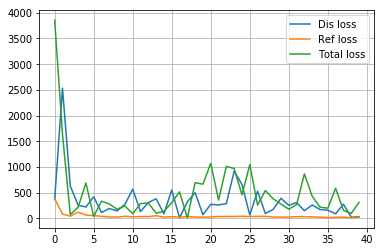

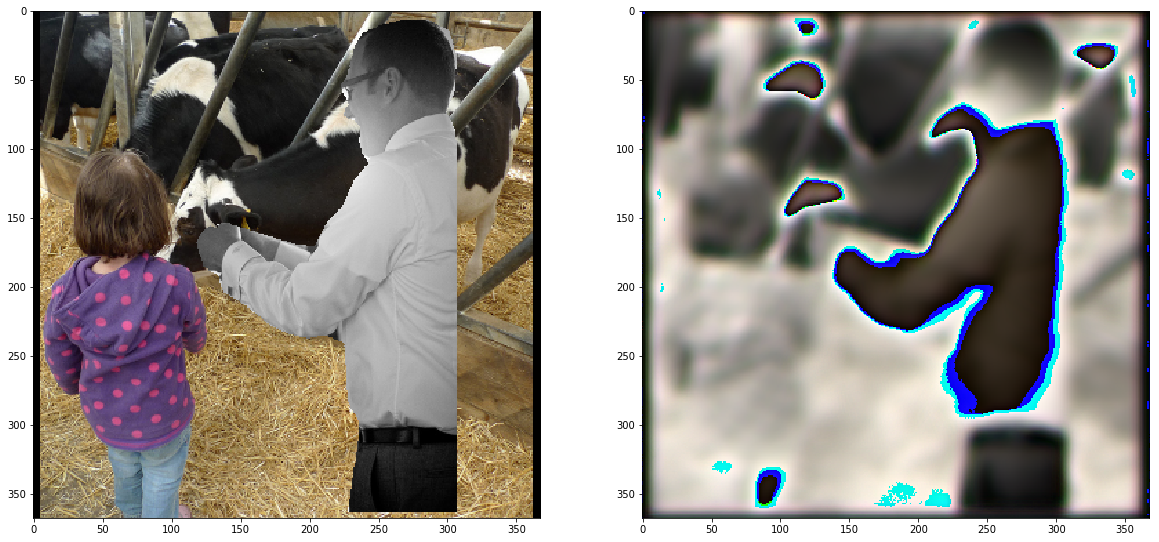

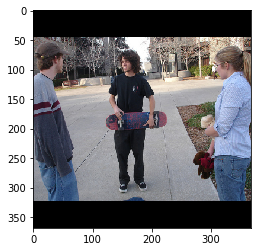

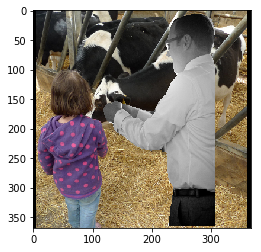

Starting the real examples thread
Starting the fake examples thread
Real examples done
Fake examples done


In [ ]:


while True:
    plt.imshow( batch_real[0].astype(np.uint8) )
    plt.show()

    plt.imshow( batch_fake[0].astype(np.uint8) )
    plt.show()

    # Set up the threads to work in the background while running GPU tasks
    list_real = list()
    list_fake = list()
    thread_real = Thread(target=get_real_examples, args=(list_real, coco, coco_kps, COCO_ROOT, imgIds, composition_params, batch_size))
    thread_fake = Thread(target=get_fake_examples, args=(list_fake, coco, coco_kps, COCO_ROOT, imgIds, composition_params, batch_size))
    
    thread_real.start()
    thread_fake.start()

    # TRAIN DISCRIMINATOR FIRST
    dis_model.trainable = True
    dis_batch_x = np.concatenate([ batch_real[0:batch_size//2,], batch_fake[0:batch_size//2,] ], axis=0)
    dis_batch_y = np.concatenate([ np.ones((batch_size//2,1)), np.zeros((batch_size//2,1)) ], axis=0)
    dis_loss_cur = dis_model.train_on_batch(dis_batch_x, dis_batch_y)

    # Train the whole model next
    dis_model.trainable = False
    full_batch_x = batch_real
    full_batch_y = np.ones((batch_size, 1))
    full_loss_cur = full_model.train_on_batch(full_batch_x, full_batch_y)

    # TRAIN AE LOSS
    ref_batch_x = np.concatenate([ batch_real[0:batch_size//2,], batch_fake[0:batch_size//2,] ], axis=0)
    ref_loss_cur = ref_model.train_on_batch(ref_batch_x, ref_batch_x)
    
    progress.append([it, dis_loss_cur, ref_loss_cur, full_loss_cur])
    
    it += 1
    
    # Wait for the threads to stop and store new training data
    thread_real.join()
    thread_fake.join()
    batch_real = np.array(list_real)
    batch_fake = np.array(list_fake)
    
    
    if it % 4 == 0:
        
        ref_out = ref_model.predict( batch_fake[0:1,] )
        
        clear_output()
        print('It: {}, Dis loss: {}, Ref loss: {}, Full loss: {}'.format(it, dis_loss_cur, ref_loss_cur, full_loss_cur))
        p = np.array(progress)
        p = p[np.max([0, p.shape[0]-100]):,]
        plt.figure()
        plt.plot( p[:,0], p[:,1] )
        plt.plot( p[:,0], p[:,2] )
        plt.plot( p[:,0], p[:,3] )
        plt.grid()
        plt.legend(['Dis loss','Ref loss', 'Total loss'])
        plt.show()
    
        plt.figure(figsize=(20,10))
        plt.subplot(1,2,1)
        plt.imshow(batch_fake[0].astype(np.uint8))
        plt.subplot(1,2,2)
        plt.imshow(ref_out[0].astype(np.uint8))
        plt.show()
    